In [1]:
#imports and data

import emcee
from multiprocessing import Pool
from multiprocessing import cpu_count
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from PyAstronomy.pyasl import binningx0dt
from scipy import optimize #scipy-1.1.0
import matplotlib.pyplot as plt
%matplotlib inline
import time


# import RV data
path = './KH15D_data_modified.txt'
data = pd.read_csv(path, delim_whitespace=True)
data['mnvel']*=1000 # convert km/s to m/s
data['errvel']*=1000

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = np.linspace(t_start,t_stop,10000)

RV = data['mnvel']
e_RV = data['errvel']
time_RV = data['time']

# import photometry data
data_new = pd.read_csv('kh15d_2020_data.txt',delim_whitespace=True)
data_new = data_new.drop(data_new[data_new.e_Imag == 9.999].index)
data2 = pd.read_csv('johnson_data.txt', delim_whitespace=True)
data3 = pd.read_csv('maffei_data_new.txt', delim_whitespace=True)

print('Data points before binning:', len(data_new)+len(data2)+len(data3))

ccd_binned, dt = binningx0dt(data_new['date'], data_new['Imag'], yerr=data_new['e_Imag'], x0=data_new['Imag'][0], dt= 0.6401, useBinCenter=True)

JD = np.concatenate((np.array([data3['JD']][0]), np.array([data2['JD']][0]), ccd_binned[:,0]))
Imag = np.concatenate((np.array([data3['Imag']][0]), np.array([data2['Imag']][0]), ccd_binned[:,1]))
e_Imag = np.concatenate((np.array([data3['e_Imag']][0]), np.array([data2['e_Imag']][0]), ccd_binned[:,2]))
e_Imag = np.sqrt(e_Imag**2+(0.1*2.5/np.log(10))**2)

print('After binning:', len(JD))

Data points before binning: 6421
After binning: 2813


In [2]:
# RV Model

def radvel_model(P, Tp, e, w, K, E):

    # solve for true anomaly
    true_anomaly = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2.))
    
    # excluding centre of mass motion
    reflex_RV = K*(np.cos(true_anomaly+w)+e*np.cos(w)) 
    
    gamma = np.sum((RV - reflex_RV)/e_RV**2)/np.sum(1/e_RV**2)

    # return RV
    return reflex_RV + gamma

def calculate_RV_chi2(RV, e_RV, time_RV, P, Tp, e, w, I):
    m_A = 0.6*2e30
    m_B = 0.72*2e30
    G = 6.6741e-11
    w, I = w*(np.pi/180), I*(np.pi/180)
    K = np.cbrt((2*np.pi*G*m_B**3*(np.sin(I))**3)/((P*86400)*(m_A+m_B)**2*(1-e**2)**(3/2))) 
    
    M = (2*np.pi/P)*(np.array(time_RV - np.ones(12)*Tp))
    
    f_list = [] 
    for M_index in range(len(M)):    
        f_list.append(lambda E:E - e*np.sin(E) - M[M_index])
    
    # make a list of E values
    E = np.zeros(len(M))
    for M_index in range(len(M)):    
        E[M_index] = optimize.brentq(f_list[M_index], -5000, 5000)
        
    RV_model = radvel_model(P, Tp, e, w, K, E)
    chi2 = 0
    for i in range(len(np.array(time_RV))):
        chi2+= (np.array(RV)[i] - RV_model[i])**2/np.array(e_RV)[i]**2
    return chi2


In [3]:
# Photometric Model

def photometric_model(JD, Imag, e_Imag, LB, epsilon1, 
                    epsilon2, Xi_1, Xi_2, t3, t6, thetaL1_dot, thetaL2_dot, thetaT_dot, thetaL_t3, thetaT_t3, YL_dot, YT_dot, 
                    YL_t0, YT_t0, P, Tp, e, w, I, E, greg_date):
    
    m_A, m_B = 0.6*2e30, 0.72*2e30
    R_A, R_B = 1.3*6.96e8, 1.365*6.96e8 
    G = 6.6741e-11
    u = 0.65
    I0 = (1-epsilon1*(1+2/Xi_1)-epsilon2)/(np.pi*(1-u/3))
    epsilon_star = I0*np.pi*(1-u/3)
    a = np.cbrt((P*86400)**2*G*(m_A+m_B)/(4*np.pi**2))
    
    def edge(x, t, theta, Y_t0, Y_dot):  
        return np.tan(theta)*x + (Y_t0 + Y_dot*t)

    def leading_flux_edge(v):
        F = 0
        if v < -1:
            F = epsilon1*(1+2/Xi_1-np.exp((v+1)/Xi_1)) + epsilon_star + epsilon2
        if v > -1 and v < 1:
            F = epsilon2 + epsilon_star/2 - I0*((1-u)*(v*np.sqrt(1-v**2)+np.arcsin(v))+np.pi/2*u*v*(1-v**2/3))+epsilon1*(1-v)/Xi_1
        if v > 1:
            F = epsilon2*np.exp(-(v-1)/Xi_2)
        return F

    def tail_flux_edge(v):
        F = 0
        if v < -1:
            F = epsilon1*(np.exp((v+1)/Xi_1))
        if v > -1 and v < 1:
            F = epsilon1*(1+(v+1)/Xi_1) + I0*((1-u)*(v*np.sqrt(1-v**2)+np.arcsin(v))+np.pi/2*u*v*(1-v**2/3))+epsilon_star/2
        if v > 1:
            F = epsilon1*(1+2/Xi_1) + epsilon_star + epsilon2*(1-np.exp(-(v-1)/Xi_2))
        return F

    def calculate_light_curve(x_a, y_a, x_b, y_b, greg_date, Imag, Imag_err, I_ref=0):

        light_curve, light_curve_A, light_curve_B = np.zeros(len(greg_date)), np.zeros(len(greg_date)), np.zeros(len(greg_date))
                        
        for i, value in enumerate(light_curve):
                                    
            if greg_date[i] < t3:
                thetaL = thetaL_t3 + thetaL1_dot*(greg_date[i]-t3) 
            if greg_date[i] > t3:
                thetaL = thetaL_t3 + thetaL2_dot*(greg_date[i]-t3)  
                
            thetaT = thetaT_t3 + thetaT_dot*(greg_date[i]-t3) 
                      
            Y_L = edge(0, greg_date[i], thetaL, YL_t0, YL_dot) 
            Y_T = edge(0, greg_date[i], thetaT, YT_t0, YT_dot)
            
            vA_L = -1/R_A*(np.sin(-thetaL)*x_a[i] + np.cos(-thetaL)*(y_a[i] - Y_L))
            vB_L = -1/R_B*(np.sin(-thetaL)*x_b[i] + np.cos(-thetaL)*(y_b[i] - Y_L))

            vA_T = -1/R_A*(np.sin(-thetaT)*x_a[i] + np.cos(-thetaT)*(y_a[i] - Y_T))
            vB_T = -1/R_B*(np.sin(-thetaT)*x_b[i] + np.cos(-thetaT)*(y_b[i] - Y_T))
            
            light_curve_A[i] = (leading_flux_edge(vA_L)+tail_flux_edge(vA_T)) 
            light_curve_B[i] = (leading_flux_edge(vB_L)+tail_flux_edge(vB_T))
            
            light_curve[i] = - 2.5*np.log10(light_curve_A[i] + LB*light_curve_B[i])

        I_ref = np.sum((Imag - light_curve)/Imag_err**2)/np.sum(1/Imag_err**2)
        #print('I_ref:', I_ref)
    
        return I_ref, light_curve + I_ref

    x_b, y_b = a*(np.cos(E)-e), a*np.sqrt(1-e**2)*np.sin(E)
    
    r_x = -np.sin(w)*y_b + np.cos(w)*x_b
    r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
    x_A, y_A = solve_position('a', r_x, r_y, m_A, m_B)
    x_B, y_B = solve_position('b', r_x, r_y, m_A, m_B) 
    
    return calculate_light_curve(x_A, y_A, x_B, y_B, greg_date, Imag, e_Imag)

def solve_position(star, x, y, m_A, m_B):
    if star == 'a':
        return -(m_A/m_B + 1)**-1*x, -(m_A/m_B + 1)**-1*y
    if star == 'b':
        return (m_B/m_A + 1)**-1*x, (m_B/m_A + 1)**-1*y
    
def calculate_edge(t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, a, w, I, E_edge, m_A, m_B):

        thetaL_t5 = thetaL_t3 + thetaL2_dot*(t5-t3) 
        thetaT_t6 = thetaT_t3 + thetaT_dot*(t6-t3)
        
        x_b, y_b = a*(np.cos(E_edge)-e), a*np.sqrt(1-e**2)*np.sin(E_edge)
        r_x = -np.sin(w)*y_b + np.cos(w)*x_b
        r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
        x_A, y_A = solve_position('a', r_x, r_y, m_A, m_B)
        x_B, y_B = solve_position('b', r_x, r_y, m_A, m_B)
        
        E_shift = np.arctan(-np.tan(w)*np.sqrt(1-e**2))

        def derivative_t5(E):
            #differentiated wrt E
            x_b = -a*np.sin(E)
            y_b = a*np.sqrt(1-e**2)*np.cos(E)
            r_x = -np.sin(w)*y_b + np.cos(w)*x_b
            r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))

            return (r_y/r_x - np.tan(thetaL_t5))
        
        def derivative_t6(E):
            #differentiated wrt E
            x_b = -a*np.sin(E)
            y_b = a*np.sqrt(1-e**2)*np.cos(E)
            r_x = -np.sin(w)*y_b + np.cos(w)*x_b
            r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))

            return (r_y/r_x - np.tan(thetaT_t6))
        
        # Note orbits start at -pi at the argument of periapsis (w), which happens at the time of periasis (Tp)
        t5_root = optimize.brentq(derivative_t5, E_shift + 0.000001, np.pi + E_shift - 0.000001)
        t6_root = optimize.brentq(derivative_t6, E_shift + 0.000001, np.pi + E_shift - 0.000001)
        
        def E_to_position(E):
            x_b = a*(np.cos(E)-e)
            y_b = a*np.sqrt(1-e**2)*np.sin(E)
            x = -np.sin(w)*y_b + np.cos(w)*x_b
            y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
            return x, y
      
        # solve for projected position (x, y) of star intersecting the lead/tail edge 
        x_t5, y_t5 = E_to_position(t5_root)
        x_t6, y_t6 = E_to_position(t6_root)
        x_t5, y_t5 = solve_position('a', x_t5, y_t5, m_A, m_B)
        x_t6, y_t6 = solve_position('b', x_t6, y_t6, m_A, m_B)
        
        # solve for y-intercept of lead/tail edge at a given time
        YL_t5 = y_t5-np.tan(thetaL_t5)*x_t5
        YT_t6 = y_t6-np.tan(thetaT_t6)*x_t6

        # solve for the change in y-intercept of lead/tail edge
        YL_dot = (YL_t5-0.)/(t5-t3)
        YT_dot = alpha*YL_dot
        
        YT_t3 = YT_t6 - (t6-t3)*YT_dot
        
        # solve for the y-intercept of lead/tail edge at t=t0
        YL_t0 = YL_t5-YL_dot*t5  # using t3 or t5 give the same value
        YT_t0 = YT_t6-YT_dot*t6 

        return YL_dot, YT_dot, YL_t0, YT_t0
    
def calculate_photometric_chi2(JD, Imag, Imag_err, LB, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, P, Tp, e, w, I):
     
    w, I, thetaL_t3, thetaT_t3 = w*(np.pi/180), I*(np.pi/180), thetaL_t3*(np.pi/180), thetaT_t3*(np.pi/180)
    m_A, m_B = 0.6*2e30, 0.72*2e30
    R_A, R_B = 1.3*6.96e8, 1.365*6.96e8 
    G = 6.6741e-11
    u = 0.65
    epsilon_star = np.pi*(1-u/3)
    normalization = 3*epsilon1 + epsilon_star + epsilon2
    a = np.cbrt((P*86400)**2*G*(m_A+m_B)/(4*np.pi**2))
    greg_date = (JD - 2451545.0)/365.25 + 2000 #JD 2451545 is year 2000
    
    # for occult edge calculation
    M_edge = np.linspace(-np.pi, 3*np.pi, 1000)
    f_list = [] 
    for M_index in range(len(M_edge)):    
        f_list.append(lambda E:E - e*np.sin(E) - M_edge[M_index])
    E_edge = np.zeros(len(M_edge))
    for M_index in range(len(M_edge)):    
        E_edge[M_index] = optimize.brentq(f_list[M_index], -10, 10)
        
    # for light curve
    M = (2*np.pi/P)*(JD - Tp) # for every data point
    f_list = [] 
    for M_index in range(len(M)):    
        f_list.append(lambda E:E - e*np.sin(E) - M[M_index])
    E = np.zeros(len(M))
    for M_index in range(len(M)):    
        E[M_index] = optimize.brentq(f_list[M_index], -5000, 5000)
 
    YL_dot, YT_dot, YL_t0, YT_t0 = calculate_edge(t3, 
                    t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, a, w, I, E_edge, m_A, m_B)
                                                  
    I_ref, Imag_model = photometric_model(JD, Imag, e_Imag, LB, epsilon1, 
                    epsilon2, Xi_1, Xi_2, t3, t6, thetaL1_dot, thetaL2_dot, thetaT_dot, thetaL_t3, thetaT_t3, YL_dot, YT_dot, 
                    YL_t0, YT_t0, P, Tp, e, w, I, E, greg_date)
    
    chi2_flux = np.zeros(len(JD))
    chi2_mag = np.zeros(len(JD))
    
    for i in range(len(JD)):
        rel_flux = 100**((I_ref - Imag[i])/5)
        rel_flux_model = 100**((I_ref - Imag_model[i])/5)
        rel_flux_error = Imag_err[i]*rel_flux*np.log(10)/2.5
        rel_flux_error = np.sqrt(rel_flux_error**2 + (0.1*rel_flux)**2)
        
        chi2_flux[i] = (rel_flux - rel_flux_model)**2/rel_flux_error**2
        chi2_mag[i] = (Imag[i] - Imag_model[i])**2/Imag_err[i]**2
    
    total_chi2 = np.sum(chi2_mag)

    return total_chi2


In [4]:
# given parameters

alpha = 0.5

# RV (6)
P = 48.371 # orbital period
Tp = 2452353.54
e = 0.5705
w = 9.3 # argument of periapsis
I = 91.1
#gamma = 18578.93

P_err = 0.005
e_err = 0.017
I_err = 0.2
w_err = 2
Tp_err = 0.7
#gamma_err = 1300

# Photometric (10)
LB = 1.54
L0 = 0.0
L0_dot = 0.0
epsilon1 = 0.0470
epsilon2 = 0.0574
Xi_1 = 1.56
Xi_2 = 2.63
t3 = 1992.67
#t4 = 1997.1
t5 = 2007.93
t6 = 2013.39
#t7 = 2020.5
thetaL_t3 = -14.5
thetaT_t3 = -3.6
thetaL1_dot = 0.0063
thetaL2_dot = 0.0029
thetaT_dot = -0.0022

LB_err = 0.1
L0_err = 0.005
L0_dot_err = 0.00005
epsilon1_err = 0.01  
epsilon2_err = 0.003
Xi_1_err = 0.3
Xi_2_err = 0.2
t3_err = 0.11 
t5_err = 0.12
t6_err = 0.13
#t7_err = 0.14
thetaL_t3_err = 1
thetaT_t3_err = 1.5 # slope of intersection function
thetaL1_dot_err = 0.000001 
thetaL2_dot_err = 0.000001
thetaT_dot_err = 0.0000012 

initial_guess = np.array([P, Tp, e, w, I, LB, epsilon1, epsilon2, Xi_1, 
              Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot])
initial_error = np.array([P_err, Tp_err, e_err, w_err, I_err, LB_err,
              epsilon1_err, epsilon2_err, Xi_1_err, Xi_2_err, t3_err, t5_err, t6_err,
              thetaL_t3_err, thetaT_t3_err, thetaL1_dot_err, thetaL2_dot_err, thetaT_dot_err])


In [5]:
# Testing model on given parameters

#start = time.time()
            
RV_chi2 = calculate_RV_chi2(RV, e_RV, time_RV, P, Tp, e, w, I)
photometric_chi2 = calculate_photometric_chi2(JD, Imag, e_Imag, LB, epsilon1,
    epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, P, Tp, e, w, I)
print(RV_chi2, photometric_chi2)

#end = time.time()
#print(end-start)

18.179877431055534 21404.714891653253


In [6]:
#MCMC

def log_likelihood(theta, RV, e_RV, time_RV, JD, Imag, e_Imag):
    
    P, Tp, e, w, I, LB, epsilon1, epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot = theta
    RV_chi2 = calculate_RV_chi2(RV, e_RV, time_RV, P, Tp, e, w, I)
    photometric_chi2 = calculate_photometric_chi2(JD, Imag, e_Imag, LB, epsilon1,
        epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, P, Tp, e, w, I)
    #print(RV_chi2, photometric_chi2)
    return -0.5*(photometric_chi2 + 150*RV_chi2)

def log_prior(theta):  
    
    P, Tp, e, w, I, LB, epsilon1, epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot = theta
    if P>0.0 and w>0.0 and I>91.0 and 0.2<e<0.9 and 0.5<LB<3.0 and 0.0<epsilon1<1.0 and 0.0<epsilon2<1.0 and t5>2005.0 and t6>2008.0:
        return 0
    return -np.inf

def log_probability(theta, RV, e_RV, time_RV, JD, Imag, e_Imag):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, RV, e_RV, time_RV, JD, Imag, e_Imag)

pos = initial_guess + initial_error*(0.1*np.random.randn(36, 1))
nwalkers, ndim = pos.shape

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

with Pool() as pool:
    sampler  = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(RV, e_RV, time_RV, JD, Imag, e_Imag), pool=pool)
    sampler.run_mcmc(pos, 20000, progress=True)

64 CPUs


100%|██████████| 20000/20000 [5:48:48<00:00,  1.05s/it]  


walker plot, plotting every 50th point

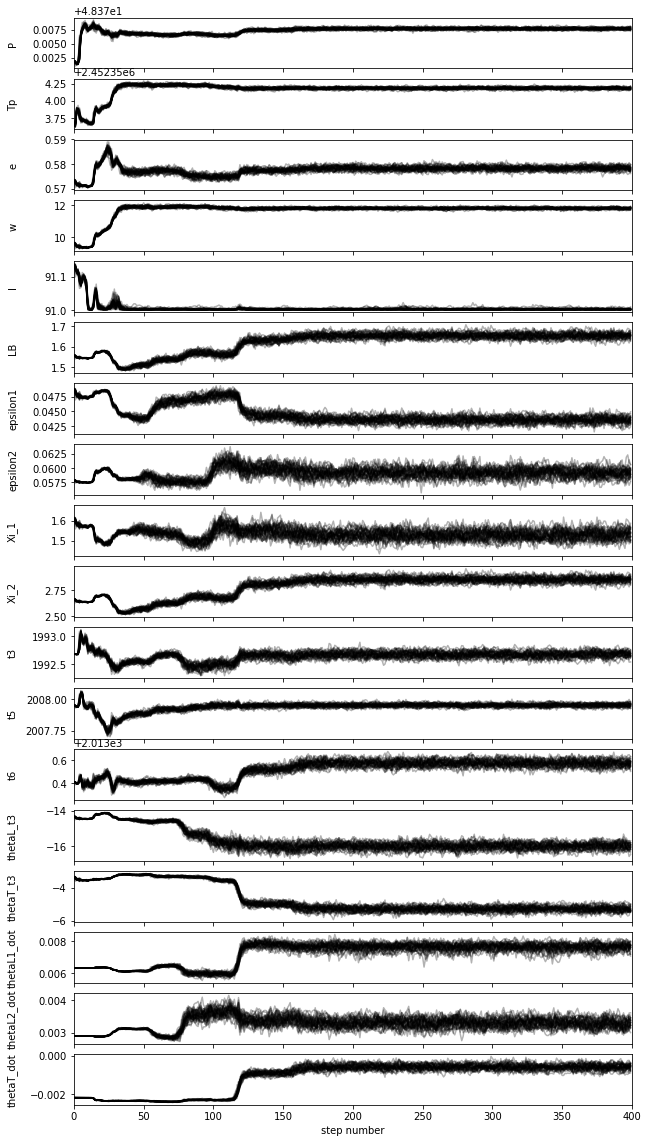

In [7]:
# walker plot, plotting every 50th point

fig, axes = plt.subplots(18, figsize=(10, 20), sharex=True)
samples = sampler.get_chain(discard=0, thin=50)
labels = ['P', 'Tp', 'e', 'w', 'I', 'LB', 'epsilon1', 'epsilon2', 
          'Xi_1', 'Xi_2', 't3', 't5', 't6', 'thetaL_t3', 'thetaT_t3', 'thetaL1_dot', 'thetaL2_dot', 'thetaT_dot']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

walker plot (discarded first 25000)

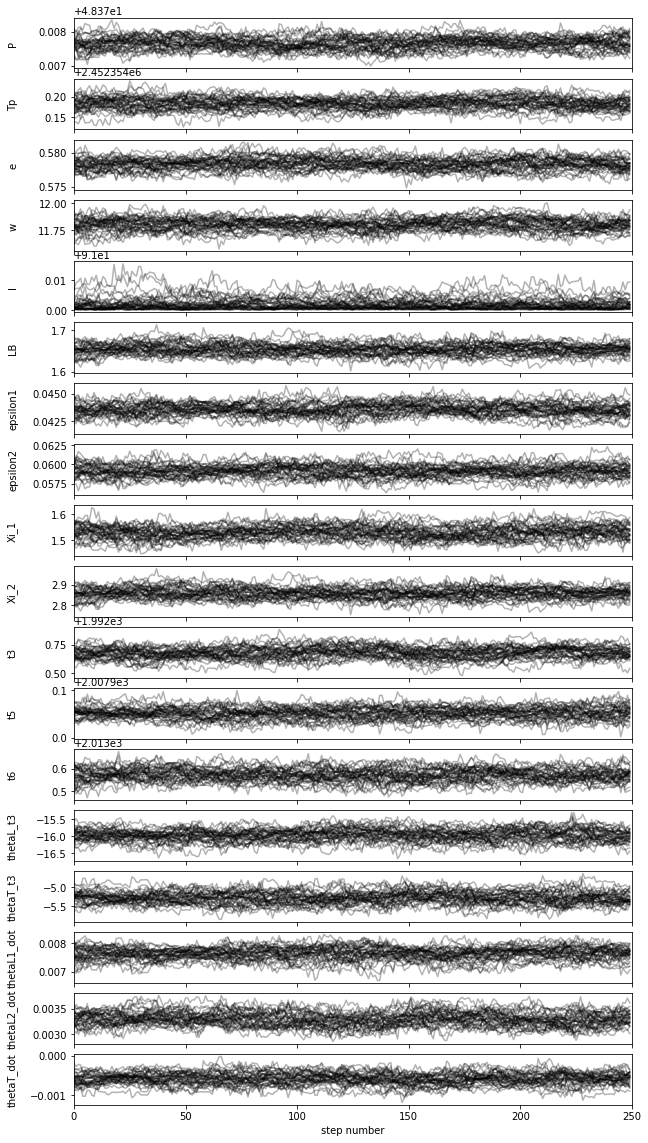

In [8]:
# walker plot (discarded first 15000)

fig, axes = plt.subplots(18, figsize=(10, 20), sharex=True)
samples = sampler.get_chain(discard=17500, thin=10)
labels = ['P', 'Tp', 'e', 'w', 'I', 'LB', 'epsilon1', 'epsilon2', 
          'Xi_1', 'Xi_2', 't3', 't5', 't6', 'thetaL_t3', 'thetaT_t3', 'thetaL1_dot', 'thetaL2_dot', 'thetaT_dot']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

final parameters below, same units as Winn et al. 2005

In [10]:
# final parameters, same units as Winn et al. 2005
from IPython.display import display, Math

flat_samples = sampler.get_chain(discard=17500, thin=10, flat=True)
optimal_values = np.zeros(18)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    optimal_values[i] = np.percentile(flat_samples[:, i], [50])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
print(optimal_values)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[ 4.83776596e+01  2.45235418e+06  5.78367747e-01  1.18026056e+01
  9.10013920e+01  1.65394863e+00  4.35520082e-02  5.91361906e-02
  1.52947111e+00  2.85789726e+00  1.99268129e+03  2.00795202e+03
  2.01357165e+03 -1.59649619e+01 -5.27843668e+00  7.65528264e-03
  3.28881258e-03 -5.79936313e-04]


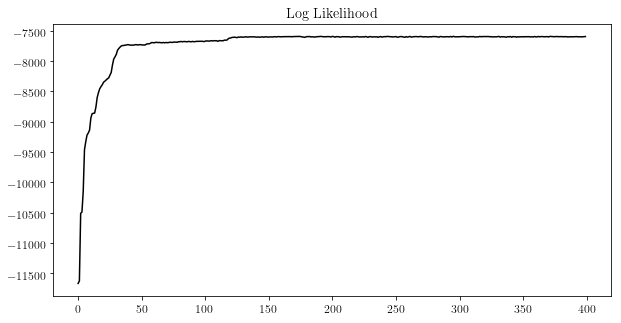

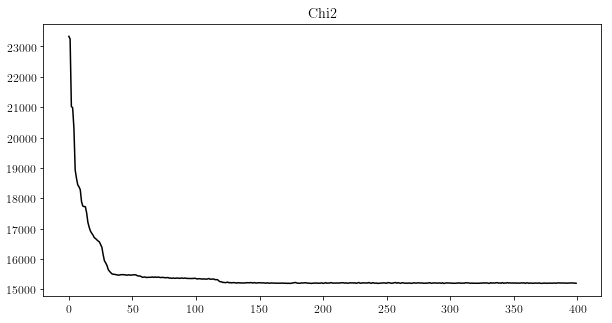

15190.9635870289


In [11]:
# chi2 plot

samples = sampler.get_log_prob(discard=0, thin=50)
plt.figure(figsize=(10,5))
plt.plot(samples[:, i], "k")
plt.title('Log Likelihood')
#plt.xlim(2500, 20000)
#plt.ylim(0, 20000)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(-2*samples[:, i], "k")
plt.title('Chi2')
#plt.xlim(2500, 20000)
#plt.ylim(0, 20000)
plt.show()

print(np.min(-2*samples[:, i]))

#print(-2*samples[:, i][0])
#print(-2*samples[:, i][-1])

In [12]:
rcParams["text.usetex"] = False

1


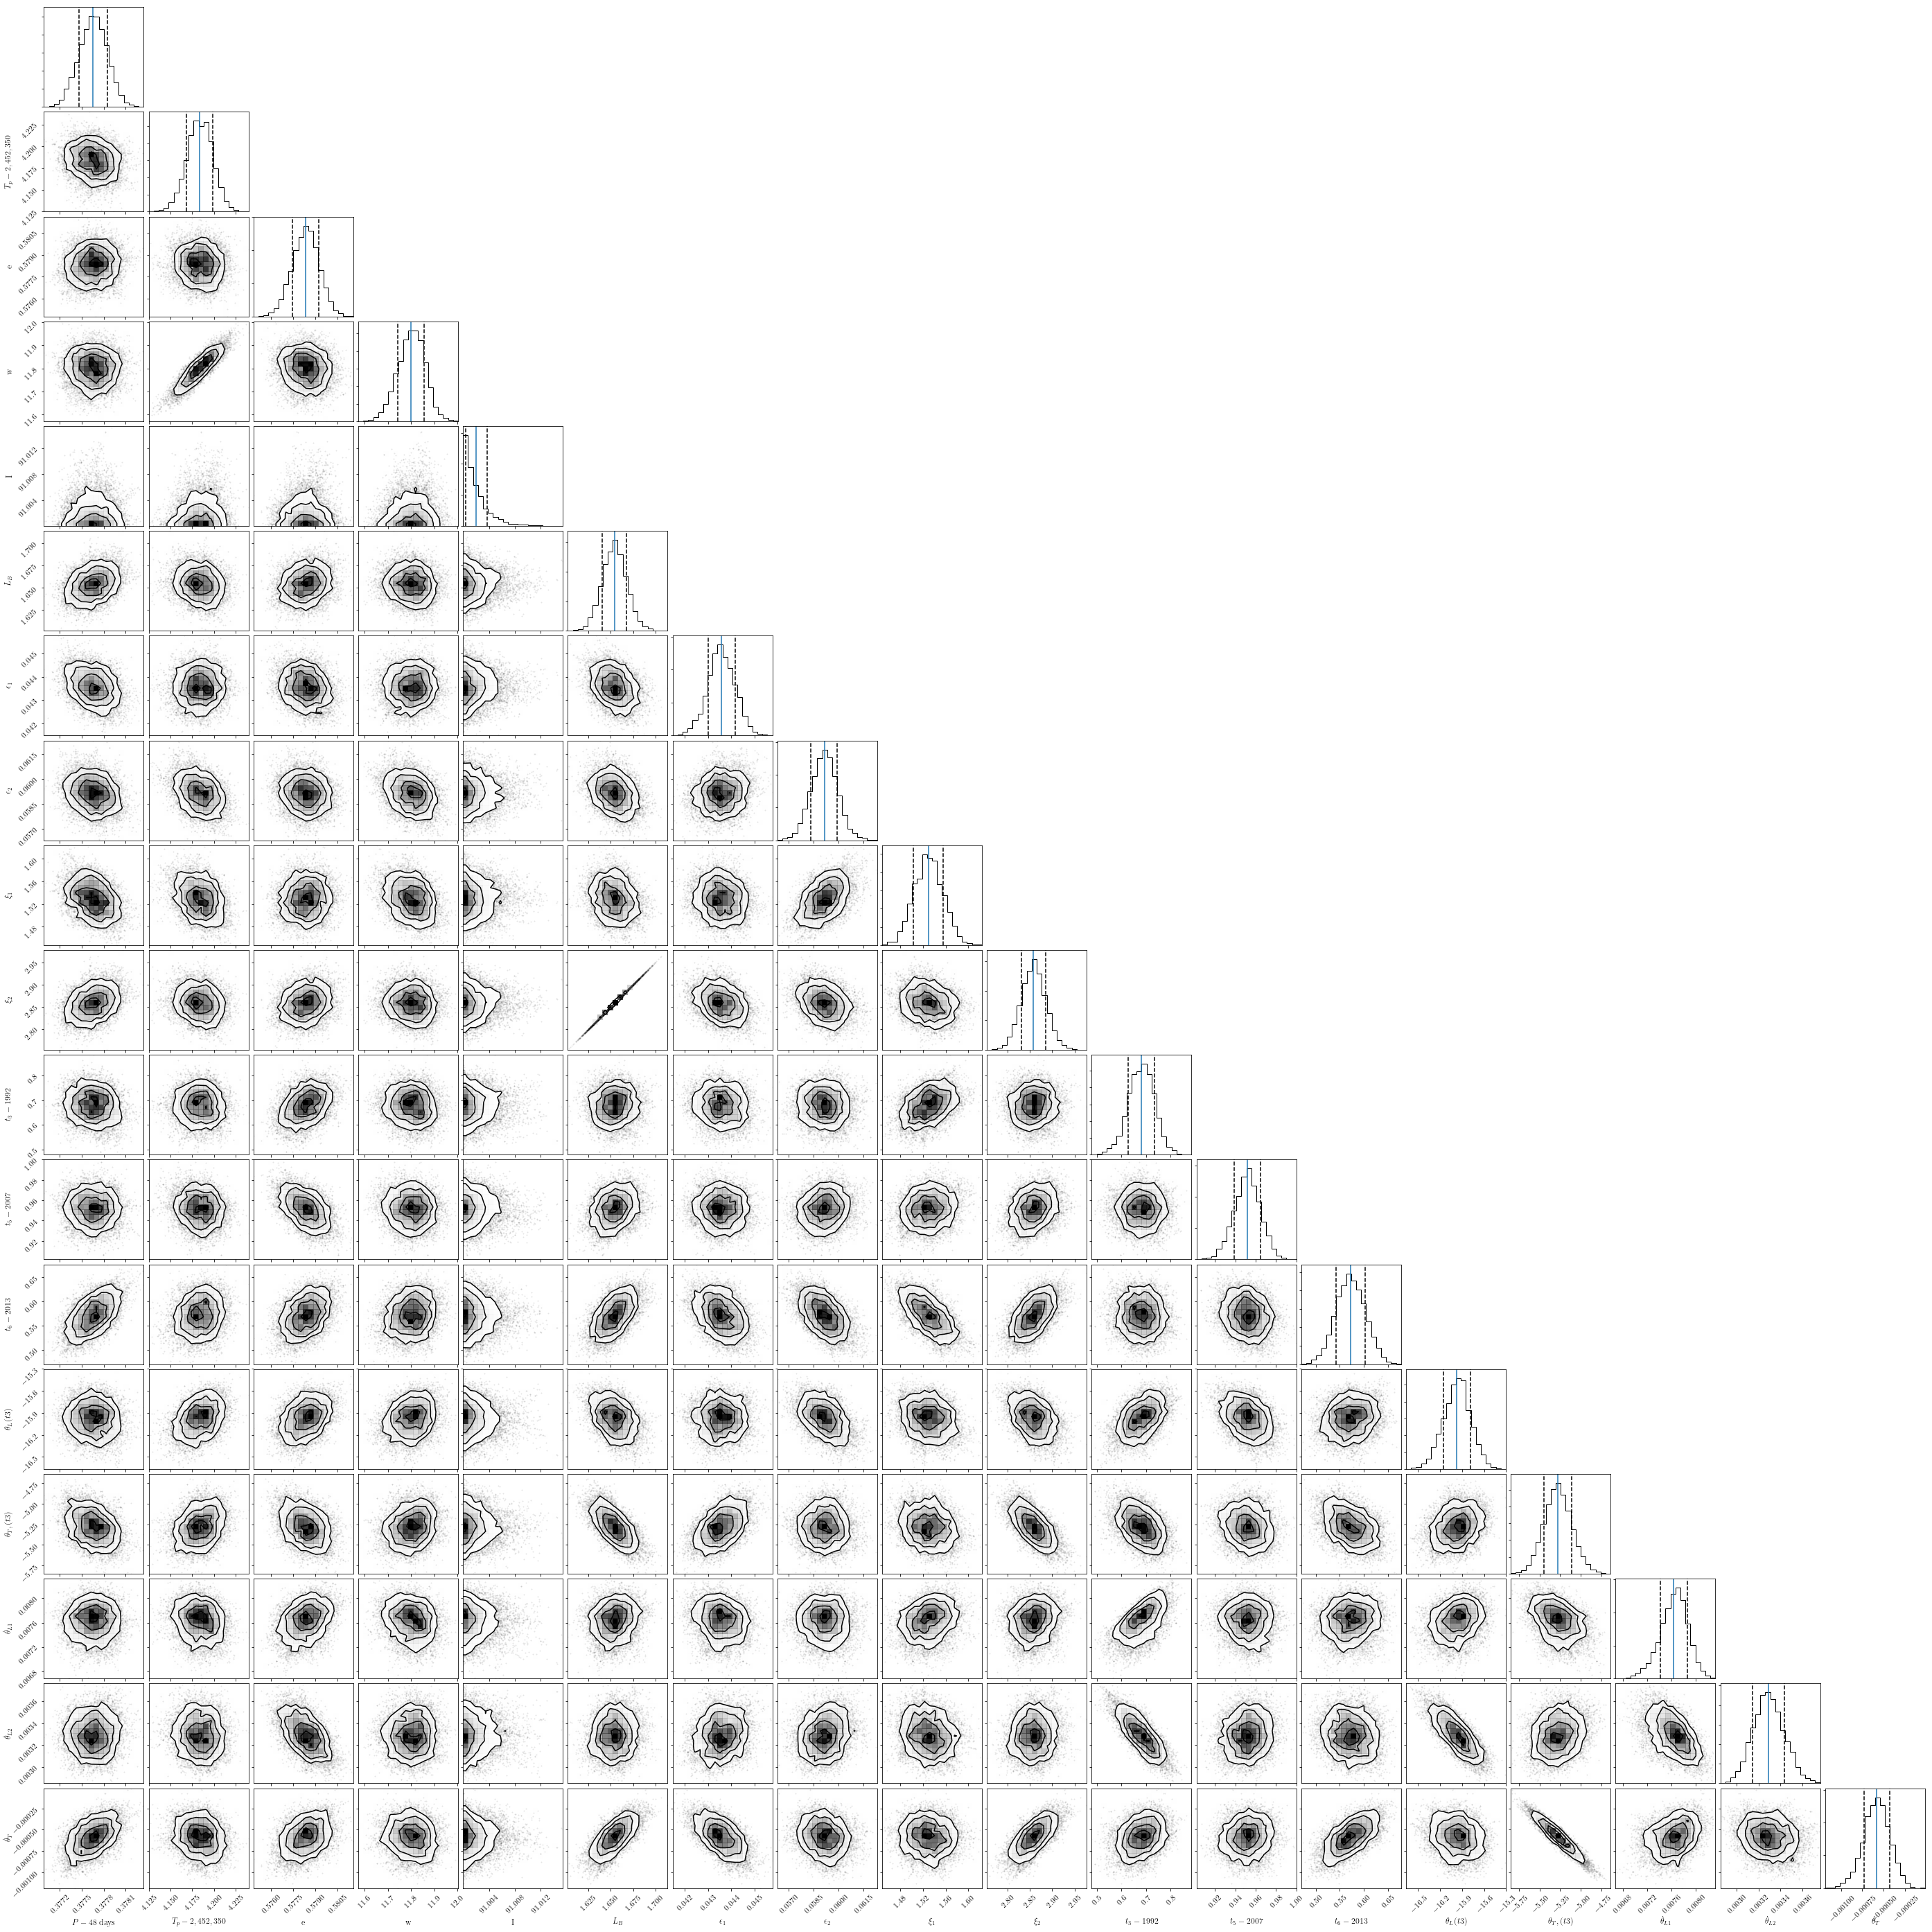

In [21]:
from matplotlib import rcParams
rcParams["font.size"] = 12
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = True

flat_samples = sampler.get_chain(discard=17500, thin=10, flat=True)
var_offsets = np.zeros(18)
var_offsets[0] = 48.0
var_offsets[1] = 2452350.
var_offsets[10] = 1992.
var_offsets[11] = 2007.
var_offsets[12] = 2013.

flat_samples = np.apply_along_axis(np.subtract, 1, flat_samples, var_offsets)
import corner
fig = corner.corner(flat_samples, quantiles=(0.16, 0.84), labels=['$P-48$ days', '$T_p-2,452,350$', 'e', 'w', 'I', '$L_B$', '$\epsilon_1$', '$\epsilon_2$', 
          r'$\xi_1$', r'$\xi_2$', '$t_3-1992$', '$t_5-2007$', '$t_6-2013$', r'$\theta_L(t3)$', r'$\theta_T,(t3)$', r'$\dot{\theta}_{L1}$', r'$\dot{\theta}_{L2}$', r'$\dot{\theta}_T$'])

mean = np.mean(flat_samples, axis=0)
axes = np.array(fig.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(mean[i])
    
fig.savefig("corner_alpha0point5_new.pdf", dpi=50,pad_inches=0.3,bbox_inches='tight')

In [17]:
# Testing model on given parameters

P, Tp, e, w, I, LB, epsilon1, epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot = optimal_values
            
RV_chi2 = calculate_RV_chi2(RV, e_RV, time_RV, P, Tp, e, w, I)
photometric_chi2 = calculate_photometric_chi2(JD, Imag, e_Imag, LB, epsilon1,
    epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, P, Tp, e, w, I)
print(RV_chi2, photometric_chi2)

#end = time.time()
#print(end-start)

12.88012851247413 13327.373184218446
